# Gradient Boost

In [2]:
# Core
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)




In [3]:
# Carga de particiones ya preparadas
train_under = pd.read_csv("../data/bogie_train_under_1a5.csv")
valid       = pd.read_csv("../data/bogie_valid.csv")
test        = pd.read_csv("../data/bogie_test.csv")

In [4]:
# Columnas que NO entran como features
cols_to_exclude = [
    "timestamp",
    "train_id",
    "bogie_id",
    "target_fault",   # objetivo
    "alarm_level",    # pseudo-target
    "fault_type"      # pseudo-target
]

all_cols = train_under.columns.tolist()
feature_cols = [c for c in all_cols if c not in cols_to_exclude]

print("Nº de features:", len(feature_cols))

X_train = train_under[feature_cols].copy()
y_train = train_under["target_fault"].copy()

X_valid = valid[feature_cols].copy()
y_valid = valid["target_fault"].copy()


Nº de features: 28


In [5]:
# Modelo base: parámetros moderados para evitar sobreajuste inicial
gb = GradientBoostingClassifier(
    n_estimators=300,      # número de árboles
    learning_rate=0.05,   # paso de aprendizaje
    max_depth=3,          # profundidad de cada árbol
    subsample=0.8,        # usar parte de las muestras en cada iteración
    random_state=42
)

gb.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.05
,n_estimators,300
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [6]:
# Probabilidades y predicciones en valid
y_valid_proba = gb.predict_proba(X_valid)[:, 1]
y_valid_pred  = gb.predict(X_valid)  # umbral 0.5

# Métricas agregadas
cm = confusion_matrix(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("Matriz de confusión (valid):\n", cm)
print("\nROC-AUC (valid):", roc)
print("PR-AUC  (valid):", pr_auc)
print("\nInforme clasificación (valid):")
print(classification_report(y_valid, y_valid_pred, digits=3))


Matriz de confusión (valid):
 [[28905    22]
 [  446     0]]

ROC-AUC (valid): 0.5072091166243278
PR-AUC  (valid): 0.015674474781892905

Informe clasificación (valid):
              precision    recall  f1-score   support

         0.0      0.985     0.999     0.992     28927
         1.0      0.000     0.000     0.000       446

    accuracy                          0.984     29373
   macro avg      0.492     0.500     0.496     29373
weighted avg      0.970     0.984     0.977     29373



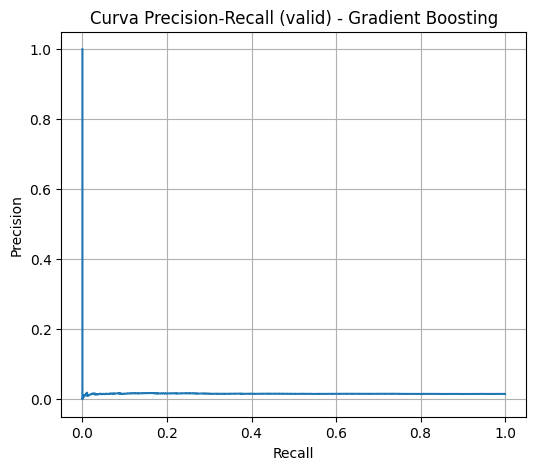

In [7]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (valid) - Gradient Boosting")
plt.grid(True)
plt.show()


### Evaluación del modelo Gradient Boosting

- La matriz de confusión en el conjunto de validación muestra que el modelo clasifica prácticamente todos los registros como "no fallo" (clase 0), produciendo 28.905 verdaderos negativos, 22 falsos positivos y 446 falsos negativos, sin ningún verdadero positivo. Esto implica que el modelo no llega a detectar ni un solo fallo real.

- Las métricas globales confirman este comportamiento:
  - Recall de la clase 1 (fallos): 0.0, es decir, el modelo no identifica ningún fallo.
  - ROC-AUC ≈ 0.51 y PR-AUC ≈ 0.016, valores apenas superiores al comportamiento aleatorio, lo que indica que las probabilidades generadas por el modelo no ordenan de forma útil los casos con fallo frente a los casos sin fallo.

- A pesar de que la accuracy total es alta (~98 %), esta métrica es engañosa en un problema tan desbalanceado: el modelo obtiene un buen porcentaje de aciertos simplemente porque casi todos los ejemplos pertenecen a la clase 0. Desde la perspectiva de negocio, un modelo que no detecta ningún fallo carece de valor para la planificación de mantenimiento predictivo.

- En consecuencia, este modelo de Gradient Boosting en su configuración base se descarta como solución final. Será necesario explorar otras configuraciones, algoritmos más adecuados o un enriquecimiento adicional de las variables de entrada antes de conseguir un rendimiento aceptable en la detección de fallos.
